In [57]:
import os
import pandas as pd
import xml.etree.ElementTree as ET

# Define the root directory path
root_path = 'D:\\Work\\Data\\Paper_Projects\\GEEKnowledgeTemplate\\evaluation\\gee_template_result'
# folders = ['gpt3_5-1', 'gpt3_5-2', 'gpt3_5-3', 'gpt3_5-4', 'gpt3_5-5']
folders = ['gpt4-1', 'gpt4-2', 'gpt4-3', 'gpt4-4', 'gpt4-5']

# Collect all file names
file_names = set()
for folder in folders:
    folder_path = os.path.join(root_path, folder)
    file_names.update(os.listdir(folder_path))

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate through each file name
for file_name in file_names:
    if file_name.endswith('.xml'):
        time_ranges = []
        geospatial_values = []
        all_source_values = []
        task_values = []

        # Look for this file in each folder
        for folder in folders:
            file_path = os.path.join(root_path, folder, file_name)
            if os.path.exists(file_path):
                # Parse the XML file
                tree = ET.parse(file_path)
                root = tree.getroot()
                source_values = []
                
                # Extract relevant information
                for fact in root.findall('.//Fact'):
                    # Time ranges
                    start_time = fact.find('.//StartTime').text if fact.find('.//StartTime') is not None else 'Unknown'
                    end_time = fact.find('.//EndTime').text if fact.find('.//EndTime') is not None else 'Unknown'
                    time_ranges.append(f"{start_time} - {end_time}")
                    
                    # Geospatial values
                    geospatial_value = fact.find('.//GeospatialRange/Value').text if fact.find('.//GeospatialRange/Value') is not None else 'Unknown'
                    geospatial_values.append(geospatial_value)

                    # Values for each data source
                    for source in fact.findall('.//Datasource/Source'):
                        source_value = source.find('Value').text if source.find('Value') is not None else 'Unknown'
                        source_values.append(source_value)
                    all_source_values.append(source_values)
                    
                    # Task values
                    for task in fact.findall('.//Task'):
                        task_value = task.find('Value').text if task.find('Value') is not None else 'Unknown'
                        task_values.append(task_value)

        # Add to DataFrame
        data = {
            'File Name': file_name.replace('.xml',''),
            'Time Ranges': str(time_ranges),
            'Geospatial Values': str(geospatial_values),
            'Source Values': str(all_source_values),
            'Task Values': str(task_values)
        }
        all_data = all_data.append(data, ignore_index=True)

# Sort the DataFrame by 'File Name'
all_data = all_data.sort_values(by='File Name')

# Define the CSV file path
# csv_file_path = 'D:\\Work\\Data\\Paper_Projects\\GEEKnowledgeTemplate\\evaluation\\combined_results3_5.csv'
csv_file_path = 'D:\\Work\\Data\\Paper_Projects\\GEEKnowledgeTemplate\\evaluation\\combined_results4.csv'

# Save the DataFrame as a CSV file, without the index
all_data.to_csv(csv_file_path, index=False)

print("Result has been written to CSV file.")


Result has been written to CSV file.


In [59]:
## Get statistics of results

import pandas as pd

# Read the CSV file
file_path = r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\combined_results3_5.csv'
# file_path = r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\combined_results4.csv'
df = pd.read_csv(file_path)

# Initialize two DataFrames to save the prediction results and stability scores, including the File Name column
predict_df = pd.DataFrame()
stability_df = pd.DataFrame()

# Add the File Name column
predict_df['File Name'] = df['File Name']
stability_df['File Name'] = df['File Name']

# Iterate over each column, except File Name
for column in df.columns[1:]:
    predict_results = []
    stability_scores = []

    for items in df[column]:
        # Convert the string-formatted list to an actual list
        if isinstance(items, str):
            try:
                item_list = eval(items)
            except:
                item_list = []
        else:
            item_list = items
        
        # Check if it is a list type
        if isinstance(item_list, list):
            # For nested lists, process each inner list into a string
            if column == 'Source Values' and all(isinstance(i, list) for i in item_list):
                flattened_list = [str(sublist) for sublist in item_list]
            else:
                flattened_list = item_list

            # Manually count the frequency of elements
            frequency_dict = {}
            for item in flattened_list:
                if item in frequency_dict:
                    frequency_dict[item] += 1
                else:
                    frequency_dict[item] = 1
            
            # Find the item with the highest frequency and its count
            most_common_item = None
            most_common_count = 0
            for item, count in frequency_dict.items():
                if count > most_common_count:
                    most_common_item = item
                    most_common_count = count
            
            # Calculate the stability score
            if flattened_list:
                stability_score = most_common_count / len(flattened_list)
            else:
                stability_score = 0
        else:
            most_common_item, stability_score = None, 0

        # Save the results
        predict_results.append(most_common_item)
        stability_scores.append(stability_score)

    # Add the prediction results and stability scores to the DataFrames
    predict_df[f'{column}'] = predict_results
    stability_df[f'{column}'] = stability_scores

# Output the prediction results and stability scores to two new CSV files, keeping the File Name column
predict_df.to_csv(r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\predict_results3_5.csv', index=False)
stability_df.to_csv(r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\stability_scores3_5.csv', index=False)
# predict_df.to_csv(r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\predict_results4.csv', index=False)
# stability_df.to_csv(r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\stability_scores4.csv', index=False)


In [61]:
## Calculate stability score on average
import pandas as pd

# File path for the stability scores CSV
file_path = r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\stability_scores3_5.csv'
# file_path = r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\stability_scores4.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Initialize the DataFrame for results
results_df = pd.DataFrame(df)

# Calculate the accuracy for each column and add it as the last row
accuracy_row = ['avg']
columns_to_evaluate = ['Geospatial Values', 'Source Values', 'Task Values', 'Time Ranges']

# For each column, calculate the accuracy by counting the number of 1s and dividing by the total count
for column in columns_to_evaluate:
    total_count = len(df)
    count_ones = df[column].sum()
    accuracy = count_ones / total_count
    accuracy_row.append(accuracy)

# Append the accuracy row to the results DataFrame
accuracy_df = pd.DataFrame([accuracy_row], columns=['File Name'] + columns_to_evaluate)
results_df = pd.concat([results_df, accuracy_df], ignore_index=True)

# Save the results DataFrame to a new CSV file
output_file_path = r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\stability_scores_with_avg_3_5.csv'
# output_file_path = r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\evaluation\stability_scores_with_avg_4.csv'
results_df.to_csv(output_file_path, index=False)


In [63]:
## Compare predict result and true value

import csv
import pandas as pd

# File paths
# predict_file_path = r'predict_results4.csv'
# true_file_path = r'true_value.csv'
# output_file_path = r'comparison_results4.csv'

predict_file_path = r'predict_results3_5.csv'
true_file_path = r'true_value.csv'
output_file_path = r'comparison_results3_5.csv'

# Read CSV file into a dictionary
def read_csv_to_dict(file_path):
    data = {}
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            file_name = row['File Name']
            data[file_name] = row
    return data

predict_dict = read_csv_to_dict(predict_file_path)
true_dict = read_csv_to_dict(true_file_path)

# Initialize the dictionary for comparison results
comparison_results = {}

# Column names
columns_to_compare = ['Geospatial Values', 'Source Values', 'Task Values', 'Time Ranges']

# Iterate over each file name for comparison
for file_name in predict_dict:
    result = []
    for column in columns_to_compare:
        predict_value = predict_dict[file_name][column]
        true_value = true_dict.get(file_name, {}).get(column, None)  # Return None if the file name is not in true_dict
        
        # Compare if the predicted value is the same as the true value
        result.append(1 if predict_value == true_value else 0)
    
    # Add the comparison results to the results dictionary
    comparison_results[file_name] = result

# Calculate the accuracy for each column and add it as the last row
accuracy_row = {'File Name': 'avg'}
total_entries = len(comparison_results)

for column_index, column in enumerate(columns_to_compare):
    total_correct = sum(result[column_index] for result in comparison_results.values())
    accuracy = total_correct / total_entries
    accuracy_row[column] = accuracy

# Add the accuracy row to the results dictionary
comparison_results['avg'] = [accuracy_row[column] for column in columns_to_compare]

# Sort the comparison results by file name
sorted_comparison_results = dict(sorted(comparison_results.items()))

# Convert the sorted comparison results to a DataFrame and save to a CSV file
df = pd.DataFrame.from_dict(sorted_comparison_results, orient='index', columns=columns_to_compare)
df.to_csv(output_file_path, index_label='File Name')


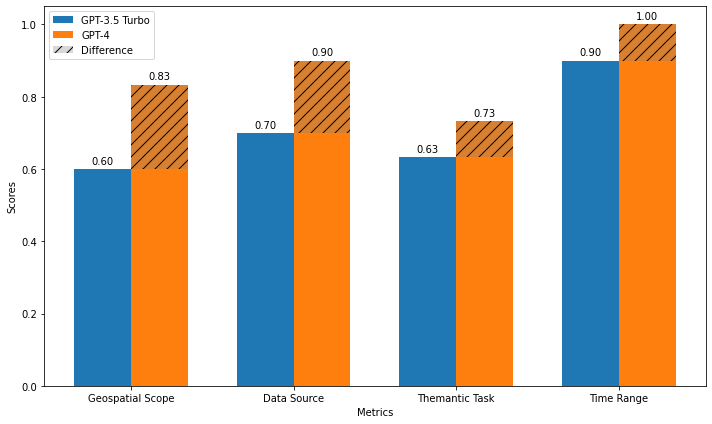

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Values for the two models
model_1 = [0.6, 0.7, 0.6333333333333333, 0.9]
model_2 = [0.8333333333333334, 0.9, 0.7333333333333333, 1.0]

# Metric labels
metrics = ['Geospatial Scope', 'Data Source', 'Themantic Task', 'Time Range']

# Bar width
bar_width = 0.35

# X-axis locations for the groups
index = np.arange(len(metrics))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for both models
bar1 = ax.bar(index, model_1, bar_width, label='GPT-3.5 Turbo')
bar2 = ax.bar(index + bar_width, model_2, bar_width, label='GPT-4')

# Calculate the differences and plot them as shaded areas with hatching
diff = np.array(model_2) - np.array(model_1)
shade = ax.bar(index + bar_width, diff, bar_width, bottom=model_1, 
               color='gray', alpha=0.3, label='Difference', hatch='//')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

# Show the plot
plt.tight_layout()
plt.show()
